## Table of Contents
1. [Load Data](#Load-Data-And-Analysis)
2. [Preprocessing](#preprocessing)
3. [Model Selection](#model-selection)
4. [Visualization](#visualization)
5. [Summary & Key Insights](#-Notebook-Summary-&-Key-Insights)

# Load Data And Analysis 

In [1]:
import kagglehub

path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\AIJimmy\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\1


In [2]:
import pandas as pd

fake_df = pd.read_csv(path + "\Fake.csv")
true_df = pd.read_csv(path + "\True.csv")

fake_df['label'] = 0
true_df['label'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)

df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
print("value counts:", df['label'].value_counts())
print("----------------------------------------")
print("Missing values:", df.isnull().sum())
print("----------------------------------------")
print("Dataset shape:", df.shape)
print("----------------------------------------")
print("info:", df.info())

value counts: label
0    23481
1    21417
Name: count, dtype: int64
----------------------------------------
Missing values: title      0
text       0
subject    0
date       0
label      0
dtype: int64
----------------------------------------
Dataset shape: (44898, 5)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
info: None


In [4]:
print("Subject value counts:", df["subject"].value_counts())

Subject value counts: subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [5]:
from datetime import datetime

def convert_timestamp_to_date(timestamp):
    for fmt in ("%B %d, %Y", "%d-%b-%y", "%d-%b-%Y", "%Y-%m-%d"):
        try:
            return datetime.strptime(timestamp, fmt).date()
        except Exception:
            continue

if df['date'].dtype == 'object':
    df['date'] = pd.to_datetime(df['date'].apply(convert_timestamp_to_date))
print("info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44898 non-null  object        
 1   text     44898 non-null  object        
 2   subject  44898 non-null  object        
 3   date     11903 non-null  datetime64[ns]
 4   label    44898 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.7+ MB
info: None


# Preprocessing

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AIJimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AIJimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AIJimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AIJimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from num2words import num2words
from nltk.corpus import wordnet
import contractions
from nltk.corpus import stopwords
import re 

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [8]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def preprocess_text(text):
    text = text.lower()
    expanded_text = contractions.fix(text)
    split_dot_text = expanded_text.replace('.', ' . ')
    html_tag_filter = re.sub(r'<[^>]*>', '', split_dot_text)
    a_z_digits_string_only = re.sub(r'[^a-zA-Z0-9]+', ' ', html_tag_filter)
    converted_num = "".join(num2words(int(word)) if word.isdigit() else word for word in a_z_digits_string_only)
    word_tokens = word_tokenize(converted_num)
    remove_stop_words = [w for w in word_tokens if not w in stop_words]
    tagged = nltk.tag.pos_tag(remove_stop_words)
    
    lemmatized_words = []
    for word, tag in tagged:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
        lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmatized_words.append(lemmatized_word)
    
    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text


In [10]:
df['Original_Text'] = df['title'] + ' ' + df['text']


df["title"]= df["title"].apply(preprocess_text)
df["text"]= df["text"].apply(preprocess_text)

In [11]:
all_text = ' '.join(df['title'].values + df['text'].values)
unique_chars = set(all_text)
print("Unique characters:", sorted(unique_chars))
print("Number of unique characters:", len(unique_chars))
df.head()

Unique characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of unique characters: 27


,title,text,subject,date,label,Original_Text
0,donald trump sends embarrass new year eve mess...,donald trump wish american happy new year leav...,News,2017-12-31,0,Donald Trump Sends Out Embarrassing New Year’...
1,drunk brag trump staffer start russian collusi...,house intelligence committee chairman devin nu...,News,2017-12-31,0,Drunk Bragging Trump Staffer Started Russian ...
2,sheriff david clarke become internet joke thre...,friday reveal former milwaukee sheriff david c...,News,2017-12-30,0,Sheriff David Clarke Becomes An Internet Joke...
3,trump obsess even obama name cod website image,christmas day donald trump announce would back...,News,2017-12-29,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,pope francis call donald trump christmas speech,pope francis use annual christmas day message ...,News,2017-12-25,0,Pope Francis Just Called Out Donald Trump Dur...


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()
df['vic_text'] = df['title'] + ' ' + df['text']

X = df['vic_text']
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Model selection

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

models_and_params = [
    {
        'name' : 'Logistic Regression',
        'model' : LogisticRegression(),
        'params' : {
            'classifier__C' : [ 0.1, 1, 10],
            'classifier__max_iter' : [100,200,300],
            'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        }
    },
    {
        'name': 'SVC',
        'model': SVC(),
        'params': {
            'classifier__C': [1],
            'classifier__kernel': ['linear'],
            'classifier__gamma': ['scale'],
        }
    },
]

for model_info in models_and_params:
    model = Pipeline(
        steps=[('classifier', model_info['model'])]
    )
    grid_search = GridSearchCV(model, model_info['params'], cv=5 , scoring='accuracy' , n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_info['name']}: {grid_search.best_params_}")
    model_info['best_model'] = grid_search.best_estimator_
for model_info in models_and_params:
    print(f"Evaluating {model_info['name']}")
    y_pred = model_info['best_model'].predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__solver': 'saga'}
Best parameters for SVC: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Evaluating Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Evaluating SVC
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [23]:
clf = models_and_params[0]["best_model"]
best_estimator = clf.named_steps['classifier']
coefs = best_estimator.coef_
coefs = coefs.ravel()
Num_of_features = 10
feature_names = vectorizer.get_feature_names_out()
pairs = list(zip(feature_names, coefs))
top_pos = sorted(pairs, key=lambda x: x[1], reverse=True)[:Num_of_features]
top_neg = sorted(pairs, key=lambda x: x[1])[:Num_of_features]
print("Top positive features:", top_pos)
print("Top negative features:", top_neg)

Top positive features: [('reuters', np.float64(56.62089753424528)), ('say', np.float64(25.222263402664964)), ('washington', np.float64(10.721756975574332)), ('wednesday', np.float64(9.518394407602932)), ('thursday', np.float64(8.358893922697611)), ('tuesday', np.float64(7.778535602589008)), ('friday', np.float64(6.90122862396148)), ('monday', np.float64(6.337484448709018)), ('comment', np.float64(6.103148211507466)), ('presidential', np.float64(6.081550366784555))]
Top negative features: [('via', np.float64(-25.60718406952264)), ('video', np.float64(-15.9893014205098)), ('read', np.float64(-15.89770996761907)), ('image', np.float64(-13.756520888972952)), ('gop', np.float64(-11.591700568354405)), ('hillary', np.float64(-10.453055126985776)), ('com', np.float64(-9.435790745583143)), ('mr', np.float64(-9.179484748645605)), ('feature', np.float64(-8.586915623985732)), ('getty', np.float64(-8.529143894070316))]


# Visualization

In [24]:
import plotly.express as px

features = [*top_pos, *top_neg]

coef_df = pd.DataFrame(features, columns=['feature', 'value'])
coef_df = coef_df.sort_values('value')

fig = px.bar(
    coef_df,
    x='value',
    y='feature',
    orientation='h',
    color='value',
    color_continuous_scale='RdYlGn',
    title='Feature Importance Bar Chart',
    range_color=[coef_df['value'].min(),    coef_df['value'].max()],
    labels={'value': 'Coefficient'},
    height=900
)
fig.update_layout(yaxis_title='Feature', xaxis_title='Coefficient', plot_bgcolor='rgba(240,240,245,1)')
fig.show()

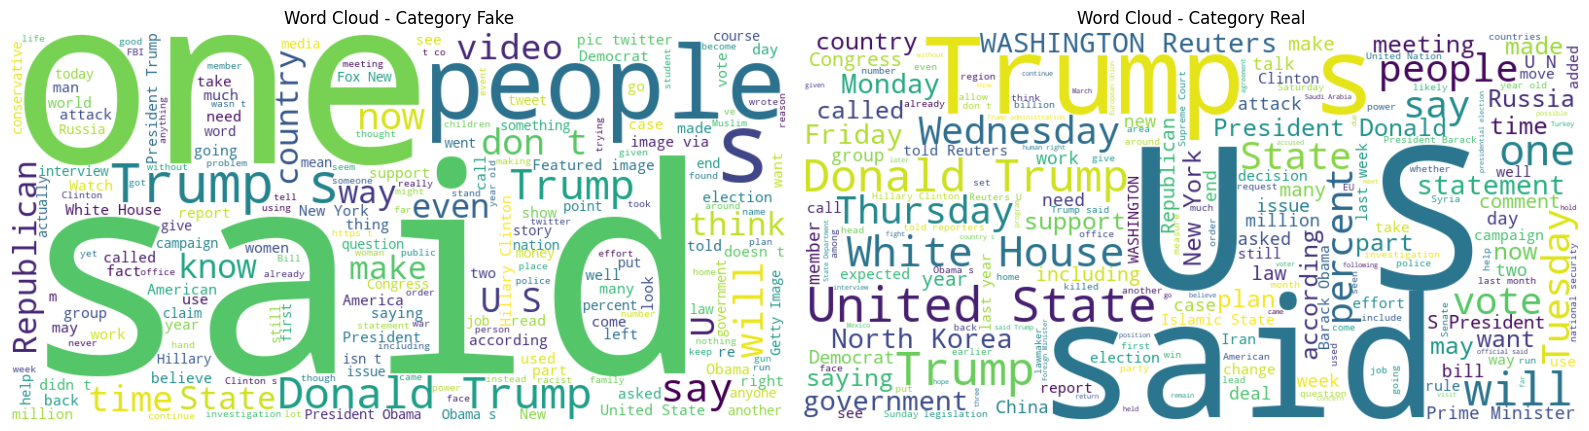

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 12))

for idx, cat in enumerate(['Fake', 'Real']):
    text = '\n'.join(df[df['label'] == idx]['Original_Text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax = axes[idx]
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Word Cloud - Category {cat}")
plt.tight_layout()
plt.show()

# Notebook Summary & Key Insights

## Summary
- Binary fake-news detection using the "Fake and Real News" dataset. Workflow: load → clean → TF‑IDF → classical classifiers → interpretability & visualizations.

## Data & Quick Checks
- Dataset combined Fake.csv (label=0) and True.csv (label=1).
- Checked class balance, missing values, subject and date distributions.
- Date parsing required tolerant handling due to mixed formats.

## Preprocessing Notes
- Text normalized: lowercasing, contraction expansion, HTML removal, non‑alphanumeric cleaning, number→words, tokenization, stopword removal, POS-aware lemmatization.
- Original_Text preserved for visualization and error analysis.
- Verify no empty documents after aggressive cleaning before vectorizing.

## Modeling & Results
- TF‑IDF features; train/test split with stratification.
- Models tuned with GridSearchCV: LogisticRegression and Linear SVC evaluated.
- Print and save classification reports; top TF‑IDF coefficients inspected for interpretation.

## Visualization & Interpretation
- Feature importance plotted (top positive / negative coefficients).
- Word clouds per class show high‑frequency words and domain signals.
- Use confusion matrix and ROC/Precision‑Recall curves to assess tradeoffs (recommended next steps).

## Key Findings
- Logistic regression/SVC give strong baseline performance on TF‑IDF features.
- Top coefficient words reveal interpretable signals differentiating fake vs real.
- Preprocessing choices (stopwords, aggressive cleaning) materially affect feature set and performance.